In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.feature import peak_local_max
import argparse
import os

In [110]:
filepath = r"C:\Users\siddh\Documents\733\Panoroma_Stitching\TraditionalWay"
imagesFolder = r"Data\Train\Set1"
saveFolder = r"Results\Set1"
showImages = True
useHarris = False
choice = 1 if useHarris else 2 # shi-Tomashi , 1 for Harris corner

In [89]:
# read the images
def readImages(filepath: str):
    print('Reading from: ', filepath)
    images = []
    files = os.listdir(filepath)
    sorted(files)
    for file in files:
        imagePath = os.path.join(filepath, file)
        image = cv2.imread(imagePath)
        if image is not None:
            images.append(image)
    print('Read ', len(images), ' images')
    return images

In [90]:
def makeImagesSizeSame(images:list[np.ndarray])->list[np.ndarray]:
    sizeList = []
    for image in images:
        x, y, ch = image.shape
        sizeList.append([x, y, ch])
    sizeArr = np.array(sizeList)
    r, c, ch = np.max(sizeArr, axis=0)
    newImages = []
    for i, image in enumerate(images):
        resized = np.zeros((r, c, sizeArr[i, 2]), np.uint8)
        resized[0:sizeArr[i, 0], 0:sizeArr[i, 1], 0:sizeArr[i, 2]] = image
        newImages.append(resized)
    return newImages
    

In [91]:
def displayImages(images:list[np.ndarray], fileName:str):
    newImages = makeImagesSizeSame(images)
    concatenated = newImages[0].copy()
    for i in range(1, len(newImages)):
        concatenated = np.concatenate((concatenated, newImages[i]), axis=1)
    cv2.imshow(fileName, concatenated)
    cv2.waitKey()
    cv2.destroyAllWindows()
    print('Writing file to ', fileName)
    cv2.imwrite(fileName, concatenated)    

In [106]:
images = readImages(os.path.join(filepath, imagesFolder))
if showImages:
    displayImages(images, os.path.join(filepath, saveFolder, 'concatenated.png'))

Reading from:  C:\Users\siddh\Documents\733\Panoroma_Stitching\TraditionalWay\Data\Train\Set1
Read  3  images
Writing file to  C:\Users\siddh\Documents\733\Panoroma_Stitching\TraditionalWay\Results\Set1\concatenated.png


In [117]:
# total images
N_images = len(images)
# split in sets
N_first_half = round(N_images/2)
N_second_half = N_images - N_first_half
print('Splitting total images in sets of', N_first_half, ',and', N_second_half)

Splitting total images in sets of 2 ,and 1


In [170]:
def detectCorners(images:list[np.ndarray], choice:int):
    print('Detecting Corners...')
    detectedCorners = []
    cmaps = []
    corner_images = []
    for i in images:
        image = i.copy()
        gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        if choice == 1:
            print("Harris corner detection method.")
            corner_strength = cv2.cornerHarris(gray_image,2,3,0.001)
            corner_strength[corner_strength<0.01*corner_strength.max()] = 0
            cmaps.append(corner_strength)
            detected_corner = np.where(corner_strength>0.0001*corner_strength.max())
            detectedCorners.append(detected_corner)
            image[detected_corner] = [0,0,255]
            corner_images.append(image)
        else:
            print("Shi-Tomashi corner detection method.")
            dst = cv2.goodFeaturesToTrack(gray_image, 1000 ,0.01, 10)
            dst = np.int0(dst)
            detectedCorners.append(dst)
            for corner in dst:
                x, y = corner.ravel()
                cv2.circle(image, (x, y) ,3 ,(0, 0, 255), -1)
            corner_images.append(image)
            # cmap not used for shi-tomashi
            cmap = np.zeros(gray_image.shape)
            cmaps.append(cmap)
    return detectedCorners, cmaps, corner_images
            


In [123]:
def show(image):
    cv2.imshow('Image', image)
    cv2.waitKey()
    cv2.destroyAllWindows()

In [175]:
detectedCorners, cmaps, cornerImages = detectCorners(images, choice)

Detecting Corners...
Shi-Tomashi corner detection method.
Shi-Tomashi corner detection method.
Shi-Tomashi corner detection method.


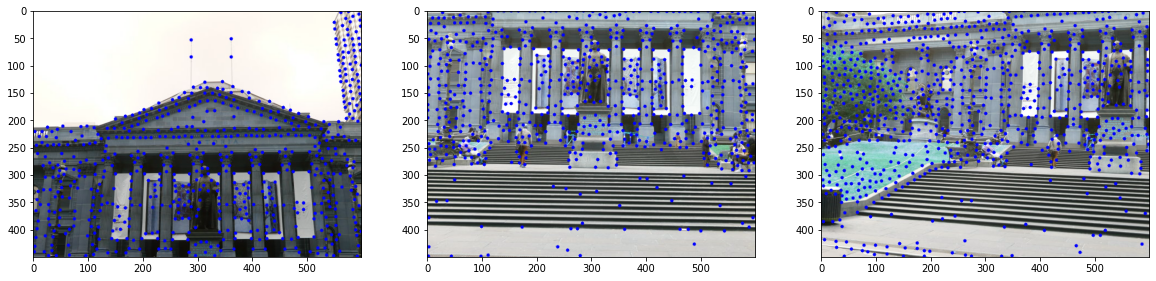

In [196]:
fig, ax = plt.subplots(1, len(cornerImages), figsize=(20,5))
for i in range(len(cornerImages)):
    ax[i].imshow(cornerImages[i])